<a href="https://colab.research.google.com/github/yongkgu/Computer_Vision/blob/main/Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## **Object Detection: Incremental Implementation**

In [2]:
# Import libraries
import numpy as np
import tensorflow as tf
import cv2 as cv
import random
from google.colab.patches import cv_imshow
import matplotlib.pyplot as plt

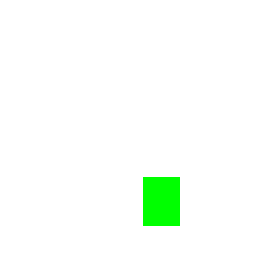

[1]


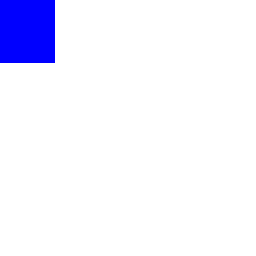

[2]


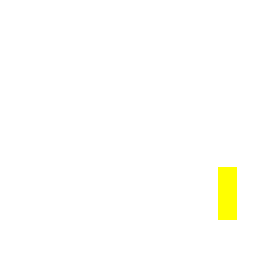

[3]


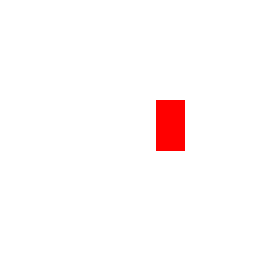

[0]


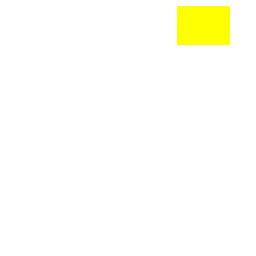

[3]


In [8]:
# Generate training images and labels
N=4000
H,W=256,256
train_img=np.zeros([N,H,W,3],dtype=np.uint8)
train_img.fill(255)
train_label_coord=np.zeros([N,2],dtype=np.int32)
train_label_size=np.zeros([N,2],dtype=np.int32)
train_label_class=np.zeros([N,1],dtype=np.int32)
bh,bw=50,50


# red(0,0,255), green(0,255,0), blue(255,0,0), yellow(0,255,255)
for n in range(N):  
  x,y=random.randint(0,H-1),random.randint(0,W-1)
  bh,bw=random.randint(int(H/16),int(H/4)),random.randint(int(W/16),int(W/4))
  if(x-bw/2<0):
    x=x-(x-bw/2)
  elif(x+bw/2>W-1):
    x=x-(x+bw/2-(W-1))
  if(y-bh/2<0): y=y-(y-bh/2)
  elif(y+bh/2>H-1):
    y=y-(y+bh/2-(H-1))
  x=int(x); y=int(y)
  train_label_coord[n,0]=x; train_label_coord[n,1]=y
  train_label_size[n,0]=bh; train_label_size[n,1]=bw

  idx = random.randint(0,3)
  train_label_class[n]= idx

  red = [0,0,255]; green = [0,255,0]; blue=[255,0,0]; yellow = [0,255,255]
  colors_ = [red,green,blue,yellow]
  cv.rectangle(train_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)), color=colors_[idx], thickness=-1)

  
# Display some images
for n in range(5):
  cv_imshow(train_img[n])
  print(train_label_class[n])

In [9]:
# Preprocess data
train_img = tf.keras.applications.vgg16.preprocess_input(train_img)
train_label_coord=train_label_coord.astype(np.float32)
train_label_coord[:,0]=train_label_coord[:,0]/H
train_label_coord[:,1]=train_label_coord[:,1]/W
train_label_size=train_label_size.astype(np.float32)
train_label_size[:,0]=train_label_size[:,0]/(H/4)
train_label_size[:,1]=train_label_size[:,1]/(W/4)

print(train_label_coord.dtype,train_label_size.dtype,train_label_class.dtype)
# Build model
base_model = tf.keras.applications.VGG16(input_shape=[H,W,3], include_top=False,weights='imagenet')
x = base_model.output
x = tf.keras.layers.Flatten()(x)
out_coord=tf.keras.layers.Dense(2,activation='sigmoid',name='out_coord')(x)
out_size=tf.keras.layers.Dense(2, activation='sigmoid',name='out_size')(x)
out_class=tf.keras.layers.Dense(4,activation='softmax',name='out_class')(x)
model=tf.keras.Model(inputs=base_model.input,outputs=[out_coord,out_size,out_class])
model.summary()

# Custom loss functions
def coord_loss_func(y_true,y_pred):
  loss_coord=tf.keras.losses.mean_squared_error(y_true,y_pred)
  return loss_coord
def size_loss_func(y_true,y_pred):
  loss_size=tf.keras.losses.mean_squared_error(y_true,y_pred)
  return loss_size
def class_loss_func(y_true,y_pred):
  loss_class=tf.keras.losses.sparse_categorical_crossentropy(y_true,y_pred)
  return loss_class



float32 float32 int32
58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
       

In [10]:
# Train and save model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
loss={'out_coord':coord_loss_func,'out_size':size_loss_func,'out_class':class_loss_func},
loss_weights={'out_coord':4,'out_size':1,'out_class':1})

history = model.fit(x=train_img,
y={'out_coord':train_label_coord,'out_size':train_label_size,'out_class':train_label_class},epochs=20,batch_size=50,validation_split=0.25)
model.save('model')

Epoch 1/20
60/60 [==============================] - 136s 2s/step - loss: 0.9601 - out_coord_loss: 0.0406 - out_size_loss: 0.0779 - out_class_loss: 0.7198 - val_loss: 0.1723 - val_out_coord_loss: 0.0204 - val_out_size_loss: 0.0638 - val_out_class_loss: 0.0269
Epoch 2/20
60/60 [==============================] - 110s 2s/step - loss: 0.0910 - out_coord_loss: 0.0093 - out_size_loss: 0.0425 - out_class_loss: 0.0113 - val_loss: 0.0492 - val_out_coord_loss: 0.0042 - val_out_size_loss: 0.0273 - val_out_class_loss: 0.0051
Epoch 3/20
60/60 [==============================] - 110s 2s/step - loss: 0.0325 - out_coord_loss: 0.0033 - out_size_loss: 0.0167 - out_class_loss: 0.0025 - val_loss: 0.0233 - val_out_coord_loss: 0.0025 - val_out_size_loss: 0.0102 - val_out_class_loss: 0.0031
Epoch 4/20
60/60 [==============================] - 110s 2s/step - loss: 0.0144 - out_coord_loss: 0.0018 - out_size_loss: 0.0060 - out_class_loss: 0.0011 - val_loss: 0.0130 - val_out_coord_loss: 0.0014 - val_out_size_loss: 

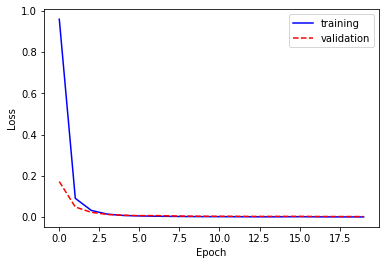

In [11]:
# Show training history
plt.figure()
plt.plot(history.history['loss'], 'b-', label='training')
plt.plot(history.history['val_loss'], 'r--', label='validation')
plt.xlabel('Epoch'), plt.ylabel('Loss'), plt.legend()
plt.show()

In [ ]:
# Generate test images and labels
N=20
H,W=256,256
test_img=np.zeros([N,H,W,3],dtype=np.uint8)
test_img.fill(255)
test_label_coord=np.zeros([N,2],dtype=np.int32)
test_label_size=np.zeros([N,2],dtype=np.int32)
test_label_class=np.zeros([N,1],dtype=np.int32)

for n in range(N):
  x,y=random.randint(0,H-1),random.randint(0,W-1)
  bh,bw=random.randint(int(H/16),int(H/4)),random.randint(int(W/16),int(W/4))
  if(x-bw/2<0):
    x=x-(x-bw/2)
  elif(x+bw/2>W-1): 
    x=x-(x+bw/2-(W-1))
  if(y-bh/2<0):
    y=y-(y-bh/2)
  elif(y+bh/2>H-1):
    y=y-(y+bh/2-(H-1))
  x=int(x); y=int(y)
  test_label_coord[n,0]=x; test_label_coord[n,1]=y
  test_label_size[n,0]=bh; test_label_size[n,1]=bw
  idx = random.randint(0,3)
  test_label_class[n]= idx # 0: red, 1: green, 2: blue, 3: yellow
  cv.rectangle(test_img[n], (x-int(bw/2),y-int(bh/2)), (x+int(bw/2),y+int(bh/2)),
  color=colors_[idx],thickness=-1)


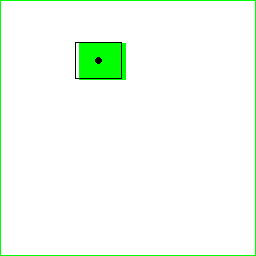

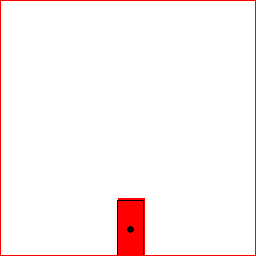

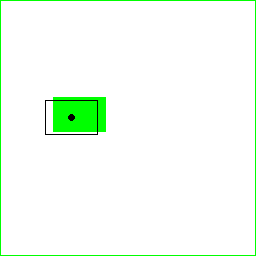

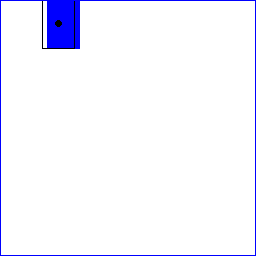

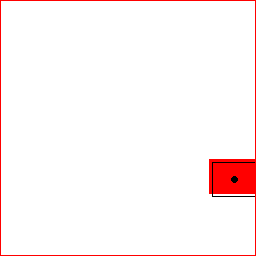

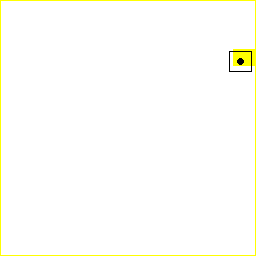

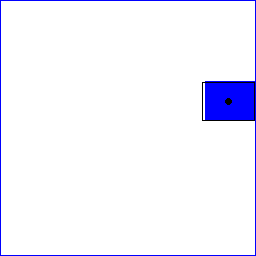

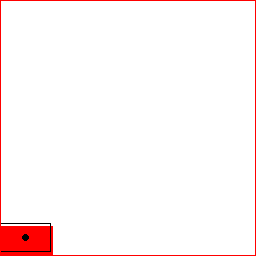

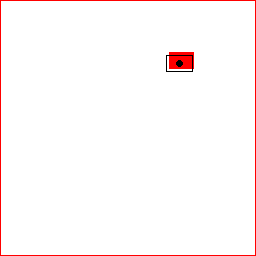

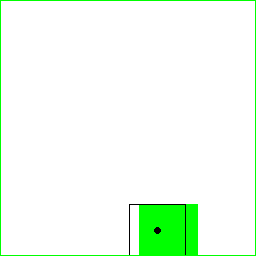

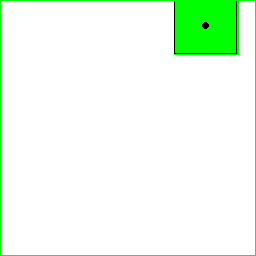

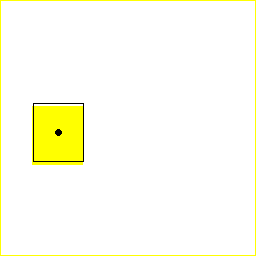

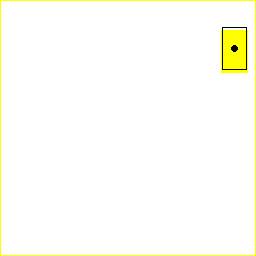

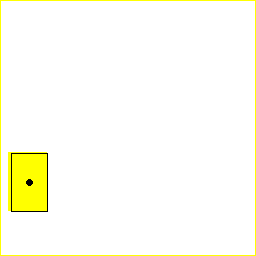

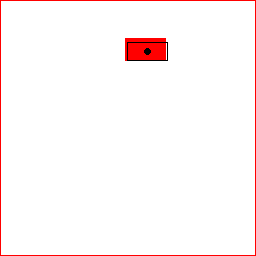

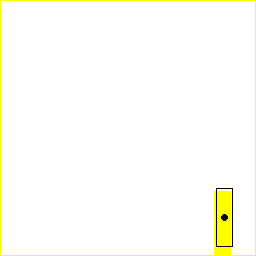

In [17]:
# Preprocess test images
test_img_ = tf.keras.applications.vgg16.preprocess_input(test_img)

# Predict object locations in test images
model=tf.keras.models.load_model('model',
custom_objects={'coord_loss_func':coord_loss_func,
'size_loss_func':size_loss_func,
'class_loss_func':class_loss_func})
pred_coord,pred_size,pred_class=model.predict(test_img_)
pred_coord[:,0]=pred_coord[:,0]*H
pred_coord[:,1]=pred_coord[:,1]*W
pred_size[:,0]=pred_size[:,0]*(H/4)
pred_size[:,1]=pred_size[:,1]*(W/4)
pred_class=np.argmax(pred_class,axis=1)

# Display prediction results
for n in range(16):

  x=pred_coord[n,0].astype('int')
  y=pred_coord[n,1].astype('int')
  bh=pred_size[n,0].astype('int')
  bw=pred_size[n,1].astype('int')
  obj_class=pred_class[n]
  
  cv.rectangle(test_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)),
  color=(0,0,0),thickness=1) # size estimation
  
  # color estimation
  if obj_class==0: # red
    cv.rectangle(test_img[n],(0,0),(W-1,H-1),color=(0,0,255),thickness=1)
  
  elif obj_class==1: # green
    cv.rectangle(test_img[n],(0,0),(W-1,H-1),color=(0,255,0),thickness=1)
  
  elif obj_class==2: #blue
    cv.rectangle(test_img[n],(0,0),(W-1,H-1),color=(255,0,0),thickness=1)
  
  else: #yellow 
    cv.rectangle(test_img[n],(0,0),(W-1,H-1),color=(0,255,255),thickness=1)
    
  #coord estimation
  cv.circle(test_img[n],center=(x,y),radius=2,color=(0,0,0),thickness=2)
  cv_imshow(test_img[n])

